In [476]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from torchvision.transforms import ToTensor
from torchvision.models import resnet18
import torch.nn.functional as F

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *
from get_data import *

In [477]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [951]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATAPATH = 'C:/Users/matan/Documents/data/coil-20-proc'
root_dir = DATAPATH + '/coil-20-proc'
csv_file = 'C:/Users/matan/Documents/data/coil-20-proc/labels.csv'
df = pd.read_csv(csv_file)

Number of images in the dataset:  1440
Image shape: torch.Size([1, 128, 128])


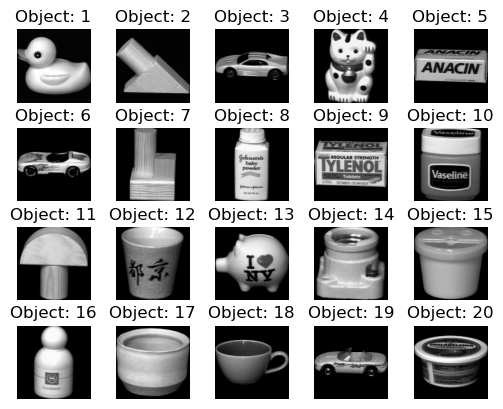

tensor(1.)
tensor([0.4471, 0.4471, 0.4431, 0.4431, 0.4275, 0.4235, 0.4157, 0.4078, 0.3922,
        0.4000, 0.4510, 0.5569, 0.6314, 0.5961, 0.5529, 0.5725, 0.5608, 0.4941,
        0.4353, 0.3490, 0.2706, 0.2588, 0.2549, 0.2784, 0.3451, 0.3412, 0.4078,
        0.4510, 0.3843, 0.3647])


In [952]:
dataset = COIL20(root_dir, csv_file, transform=ToTensor())
print("Number of images in the dataset: ", len(dataset))
img, label = dataset[0]
print("Image shape:", img.shape)

indices = {}
i = 0
while len(indices) < 20:
    _, label = dataset[i]
    if label not in indices.keys():
        indices[label] = i
    i += 1
    
fig = plt.figure()
gs = fig.add_gridspec(4,5, hspace=0.35, wspace=0)
axs = gs.subplots()
for l in range(20):
    img, label = dataset[indices[l+1]]
    assert label == l + 1
    r, c = (l)//5, l%5
    #print("label:", label, "row:", r, "col:", c)
    axs[r,c].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
    axs[r,c].set_title("Object: " + str(label))
    axs[r,c].axis('off')
plt.show()

print(torch.max(dataset[20][0]))        # Max pixel value
print(dataset[20][0][0][100][50:80])    # Print some pixel values

In [953]:
# Divide into train, test, and val
N = len(dataset)
test_size = int(0.1*N)
val_size = int(0.1*N)
train_size = N - test_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print("Training images: ", len(train_data))
print("Validation images: ", len(val_data))
print("Test images: ", len(test_data))

#kwargs = {'num_workers': 1, 'pin_memory': True} 
kwargs = {}
train_loader = DataLoader(train_data, batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, len(test_data), shuffle=True, **kwargs)
val_loader = DataLoader(val_data, len(val_data), **kwargs)

Training images:  1152
Validation images:  144
Test images:  144


# Create the model

In [954]:
resnet = resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
print(resnet)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [955]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, fc1_dim, fc2_dim, in_channels):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc1_dim, self.fc2_dim = fc1_dim, fc2_dim
        self.in_channels = in_channels
        momentum = 0.01
        #kernel_size = 3
        #init_channels = 16
        #conv_out = [init_channels*4, 16, 16]

        self.resnet = self.contruct_resnet()
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in, self.fc1_dim),
            nn.BatchNorm1d(self.fc1_dim, momentum=momentum),        # Why this momentum?
            nn.ReLU(inplace=True),
            nn.Linear(self.fc1_dim, self.fc2_dim),
            nn.BatchNorm1d(self.fc2_dim, momentum=momentum),
            nn.ReLU(inplace=True)
        )
        self.mu = nn.Linear(self.fc2_dim, self.latent_dim)
        self.var = nn.Linear(self.fc2_dim, self.latent_dim)
    
    def forward(self, x):
        #print(x.shape)
        x = self.resnet(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)   # Flatten image
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return self.mu(x), self.var(x)

    def contruct_resnet(self):
        resnet = resnet18()
        resnet.conv1 = nn.Conv2d(self.in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc_in = resnet.fc.in_features
        modules = list(resnet.children())[:-1]
        resnet = nn.Sequential(*modules)       # Resnet18, except last fc layer
        return resnet

class Decoder(nn.Module):
    def __init__(self, latent_dim, fc2_dim, fc1_dim, in_channels):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc1_dim, self.fc2_dim = fc1_dim, fc2_dim
        self.in_channels = in_channels
        momentum = 0.01
        conv_in = [64, 4, 4]

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        self.fc = nn.Sequential(
            nn.Linear(self.latent_dim, self.fc2_dim),
            nn.BatchNorm1d(self.fc2_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.fc2_dim, 64 * 4 * 4),    # Why this dim? See conv_in
            nn.BatchNorm1d(64 * 4 * 4),
            nn.ReLU(inplace=True)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=conv_in)
        self.convTrans1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4, padding=self.pd4),
            nn.BatchNorm2d(32, momentum=momentum),
            nn.ReLU(inplace=True)
        )
        self.convTrans2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3, padding=self.pd3),
            nn.BatchNorm2d(8, momentum=momentum),
            nn.ReLU(inplace=True)
        )
        self.convTrans3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=self.in_channels, kernel_size=self.k2, stride=self.s2, padding=self.pd2),
            nn.BatchNorm2d(in_channels, momentum=momentum),
            nn.Sigmoid()
        )
        

    def forward(self, z):
        #print("Decoding")
        x = self.fc(z)
        #print(x.shape)
        x = self.unflatten(x)
        #print(x.shape)
        x = self.convTrans1(x)
        x = self.convTrans2(x)
        x = self.convTrans3(x)
        #print(x.shape)
        x = F.interpolate(x, size=(128,128), mode='bilinear') # Resize?
        #print(x.shape)
        return x


class Model(nn.Module):
    def __init__(self, fc1_dim = 1024, fc2_dim = 768, latent_dim = 256, in_channels = 1):
        super(Model, self).__init__()
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.fc1_dim, self.fc2_dim = fc1_dim, fc2_dim

        self.Encoder = Encoder(latent_dim=self.latent_dim, fc1_dim=self.fc1_dim, fc2_dim=self.fc2_dim, in_channels=self.in_channels)
        self.Decoder = Decoder(latent_dim=self.latent_dim, fc1_dim=self.fc1_dim, fc2_dim=self.fc2_dim, in_channels=self.in_channels)

    def reparametrization(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(logvar).to(DEVICE) # Ransom tensor in same shape as var
            z = mean + logvar*eps
            #z = mean
        else: z = mean
        return z

    def forward(self, x):
        mean, logvar = self.Encoder(x)
        z = self.reparametrization(mean, logvar)
        x_hat = self.Decoder(z)
        return x_hat, mean, logvar

    def get_latents(self, x):
        """ Encode data x into latent representations z. """
        mean, logvar = self.Encoder(x)
        z = self.reparametrization(mean, logvar)
        return z


def loss_function(x, out, mean, log_var, N = 1152, beta = 1):
    """ Loss function for the model. """

    M = x.shape[0]      # Batch size

    #print("x.shape", x.shape, "x_hat.shape", out.shape, "logvar.shape", log_var.shape, "mean.shape", mean.shape)
    x_hat=out
    #reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    reproduction_loss = ((x - x_hat)**2).sum(dim=(1,2,3))
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)
    KL_divergence = KL_divergence * beta

    # SUM FOR BATCH LIKE IN KINGMA
    reproduction_loss = torch.sum(reproduction_loss, dim=0)
    KL_divergence = torch.sum(KL_divergence, dim=0)
    loss = (N/M) * KL_divergence + reproduction_loss

    #print("Loss:", reproduction_loss, KL_divergence)
    #print("repro loss", reproduction_loss.shape, "KL loss", KL_divergence.shape)
    return reproduction_loss + KL_divergence, reproduction_loss, KL_divergence

In [956]:
model = Model().to(DEVICE)
print(model)

Model(
  (Encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, m

### Does it run? Try to push a batch though the model

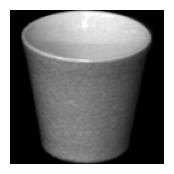

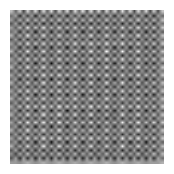

In [957]:
model.eval()
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    #x = x.view(x.size(0), dim_input)
    x = x.to(DEVICE)
    x_hat, mean, logvar = model(x)

def show_image_in_batch(images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    fig = plt.figure(figsize=(2,2))
    plt.imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, idx=0)
show_image_in_batch(x_hat, idx=0)
loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)

# Train the model

In [989]:
# Hyperparameters
batch_size = 128
lr = 0.005

in_channels = 1
input_size = [in_channels, 128, 128]
latent_dim = 512
n_classes = 20
seed = 11       # Random seed for reproducible results
torch.manual_seed(seed);

RESULTS_PATH = './model_COIL20_resnet18'

In [990]:
model = Model(latent_dim=latent_dim).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)
print(DEVICE)

cuda


In [991]:
# Train the model
epochs = 100
validation_loss = []
train_losses = []
train_r_losses = []
train_kl_losses = []
beta_vals = []
step = 0
for epoch in range(epochs):
    model.train()
    loss_this_epoch = 0
    r_loss_this_epoch = 0
    kl_loss_this_epoch = 0
    for batch, (x, label) in enumerate(train_loader):
        batch_size = x.shape[0]
        #x = x.view(batch_size, dim_input)   # Flatten
        x = x.to(DEVICE)

        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, mean, logvar = model(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        #loss = loss_function(x, out, q_mean, q_log_var)
        beta = 1#beta_func(step)
        loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=beta)
        loss_this_epoch += loss.item() 
        r_loss_this_epoch += r_loss.item()
        kl_loss_this_epoch += kl.item()
        beta_vals.append(beta)
        step += 1

        loss.backward()
        optimizer.step()

    train_losses.append(loss_this_epoch / ((batch+1)*batch_size))
    train_r_losses.append(r_loss_this_epoch / ((batch+1)*batch_size))
    train_kl_losses.append(kl_loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))
    print("\t\t\t\tReproduction loss:", r_loss_this_epoch / ((batch+1)*batch_size) ,"\tKL-div:", kl_loss_this_epoch / ((batch+1)*batch_size))

    model.eval()
    with torch.no_grad():
        for batch, (x, label) in enumerate(val_loader):
            batch_size = x.shape[0]
            #x = x.view(batch_size, dim_input)   # Flatten
            x = x.to(DEVICE)
            x_hat, q_mean, q_log_var = model(x)
            loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)
            validation_loss.append(loss.item() / len(val_data))

	Epoch 1 complete! 	Average Loss:  5730.8574660633485
				Reproduction loss: 3352.806278280543 	KL-div: 2378.0510154482467
	Epoch 2 complete! 	Average Loss:  3142.0079185520362
				Reproduction loss: 3011.4121182126696 	KL-div: 130.59578266402715
	Epoch 3 complete! 	Average Loss:  3011.254524886878
				Reproduction loss: 2900.077064479638 	KL-div: 111.17745156957014
	Epoch 4 complete! 	Average Loss:  2874.610152714932
				Reproduction loss: 2786.9799208144796 	KL-div: 87.63021422511312
	Epoch 5 complete! 	Average Loss:  2749.466628959276
				Reproduction loss: 2666.902149321267 	KL-div: 82.56442661199095
	Epoch 6 complete! 	Average Loss:  2654.652361425339
				Reproduction loss: 2575.7714932126696 	KL-div: 78.88087925975678
	Epoch 7 complete! 	Average Loss:  2543.0793976244345
				Reproduction loss: 2453.40596719457 	KL-div: 89.67343926753394
	Epoch 8 complete! 	Average Loss:  2411.6813489819006
				Reproduction loss: 2342.6773897058824 	KL-div: 69.00388857466064
	Epoch 9 complete! 	Av

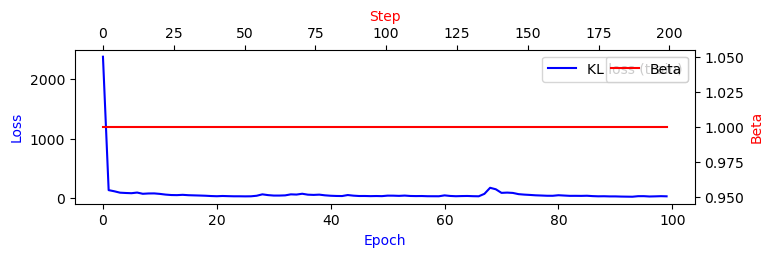

In [992]:
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(111, label='1')
ax2 = fig.add_subplot(111, label='2', frame_on=False)

ax1.plot(range(epochs), train_kl_losses, color='blue', label = "KL loss (train)")
ax1.set_xlabel("Epoch", color='blue')
ax1.set_ylabel("Loss", color='blue')
ax1.legend()

ax2.plot(range(step), beta_vals, color='red', label = "Beta")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel("Step", color='red')
ax2.set_ylabel("Beta", color='red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.legend()
plt.show()

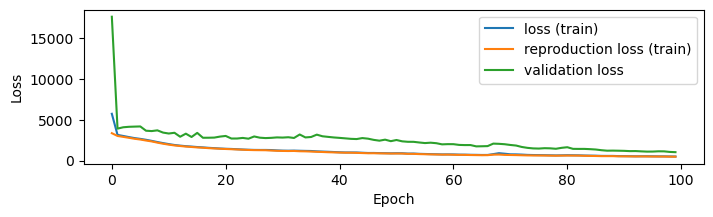

In [993]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), train_losses, label = "loss (train)")
plt.plot(range(epochs), train_r_losses, label = "reproduction loss (train)")
plt.plot(range(epochs), validation_loss, label = 'validation loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model

<Figure size 400x200 with 0 Axes>

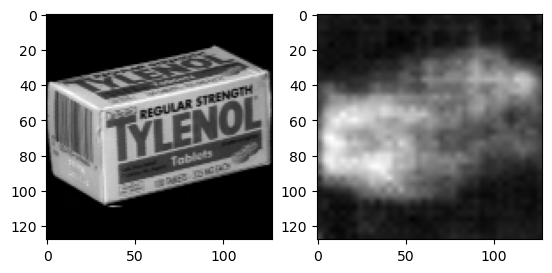

In [996]:
model.eval()

# See reconstruction of an image in the training set
img, label = train_data[900]
img_repro, _, _ = model(img.unsqueeze(0).to(DEVICE))
img_repro = img_repro.reshape(input_size).cpu().detach()
plt.figure(figsize=(4,2))
fig, axs = plt.subplots(1,2)
axs[0].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
axs[1].imshow(img_repro.permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.show()

<Figure size 400x200 with 0 Axes>

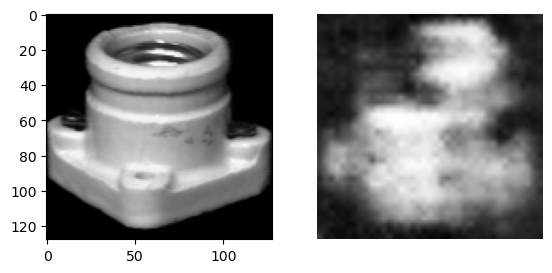

In [1004]:
model.eval()

# See reconstruction of an image in the test set
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.to(DEVICE)
    x_hat, _, _ = model(x)

def show_image_in_batch(images, reconstructed_images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    reconstructed_images = reconstructed_images.view(reconstructed_images.shape[0], input_size[-2], input_size[-1])
    #fig = plt.figure(figsize=(2,2))
    plt.figure(figsize=(4,2))
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    axs[1].imshow(reconstructed_images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, x_hat, idx=0)

C:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1152 samples in 0.001s...
[t-SNE] Computed neighbors for 1152 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1152
[t-SNE] Computed conditional probabilities for sample 1152 / 1152
[t-SNE] Mean sigma: 0.334028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.338093
[t-SNE] KL divergence after 1000 iterations: 0.314837


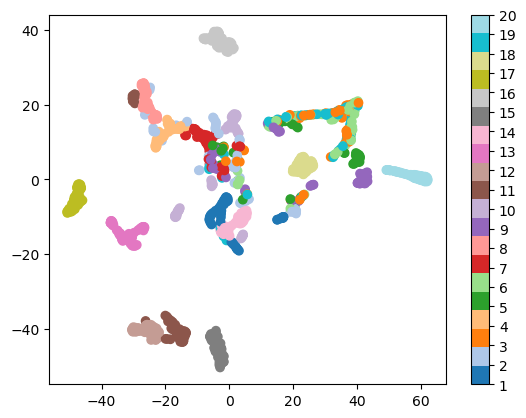

In [988]:
# Make T-SNE plot
plot_latent_space_tsne(model, train_loader)

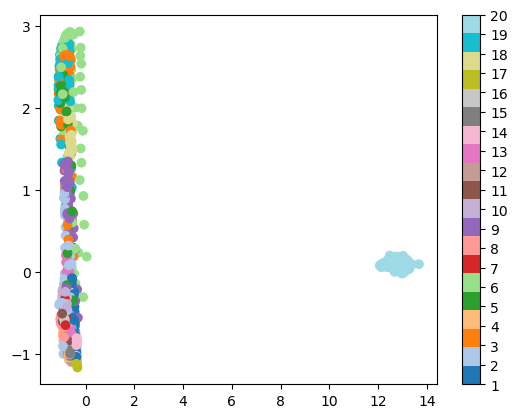

In [974]:
plot_latent_space_pca(model, train_loader, n_batches=200)

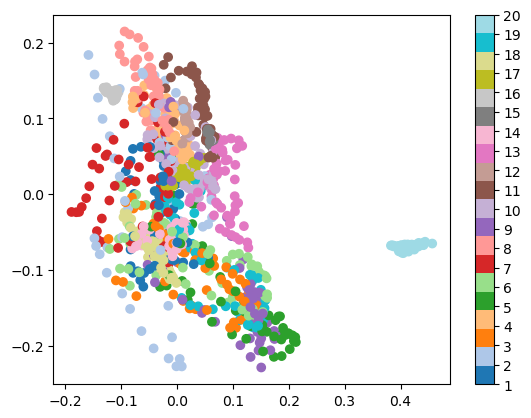

In [975]:
plot_latent_space2d(model, train_loader, dims=[4,1], n_batches=200)

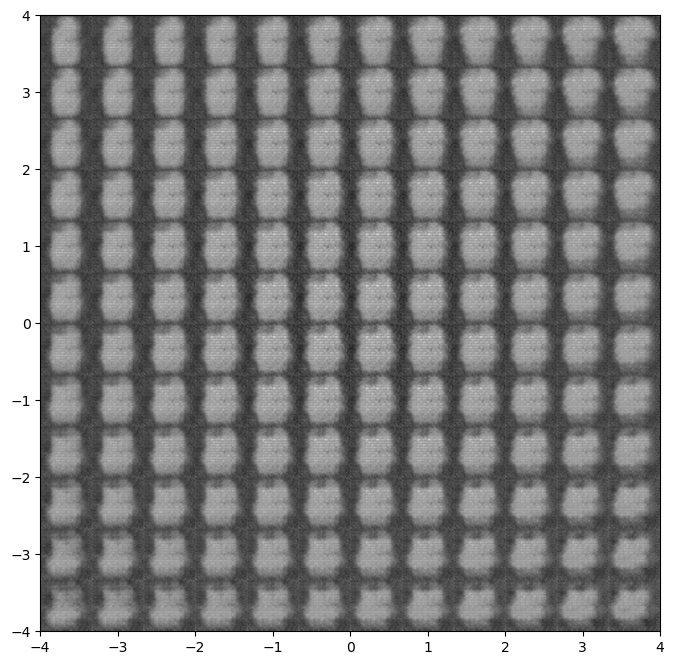

In [976]:
plot_reconstructed(model, ax0=(-4,4), ax1=(-4,4), dims=[4,1], n=12, img_size=input_size[-2:])

# Try to overfit

### Get data subset

Number of images in the dataset:  1440
Image shape: torch.Size([1, 128, 128])


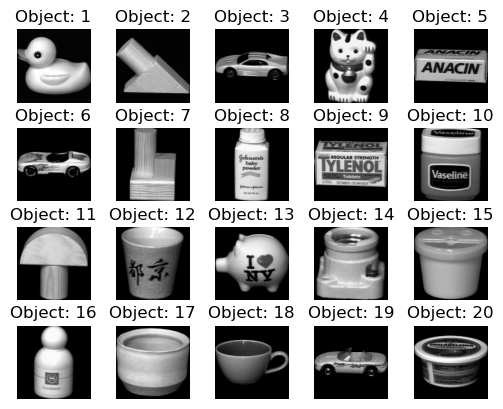

Training images:  20
Validation images:  710
Test images:  710


In [890]:
dataset = COIL20(root_dir, csv_file, transform=ToTensor())
print("Number of images in the dataset: ", len(dataset))
img, label = dataset[0]
print("Image shape:", img.shape)

indices = {}
i = 0
while len(indices) < 20:
    _, label = dataset[i]
    if label not in indices.keys():
        indices[label] = i
    i += 1
    
fig = plt.figure()
gs = fig.add_gridspec(4,5, hspace=0.35, wspace=0)
axs = gs.subplots()
for l in range(20):
    img, label = dataset[indices[l+1]]
    assert label == l + 1
    r, c = (l)//5, l%5
    #print("label:", label, "row:", r, "col:", c)
    axs[r,c].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
    axs[r,c].set_title("Object: " + str(label))
    axs[r,c].axis('off')
plt.show()

# Divide into train, test, and val
batch_size = 20
subset_idx = list(indices.values())
subset = torch.utils.data.Subset(dataset, subset_idx)
train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, **kwargs)

train_size = 20
val_size = int((N-20) / 2)
test_size = N - train_size - val_size

remaining_idx = [i for i in range(N) if i not in subset_idx]
remaining_data = torch.utils.data.Subset(dataset, remaining_idx)
val_data, test_data = random_split(remaining_data, [val_size, test_size])
print("Training images: ", len(subset))
print("Validation images: ", len(val_data))
print("Test images: ", len(test_data))

#kwargs = {'num_workers': 1, 'pin_memory': True} 
kwargs = {}
test_loader = DataLoader(test_data, len(test_data), shuffle=True, **kwargs)
val_loader = DataLoader(val_data, len(val_data), **kwargs)

In [929]:
# Hyperparameters
lr = 0.005

in_channels = 1
input_size = [in_channels, 128, 128]
latent_dim = 2048
n_classes = 20
seed = 11       # Random seed for reproducible results
torch.manual_seed(seed);

RESULTS_PATH = './model_overfit_COIL20_resnet18'

model_overfit = Model(latent_dim=latent_dim).to(DEVICE)
optimizer = Adam(model_overfit.parameters(), lr=lr)

In [930]:
# Train the model
epochs = 500
validation_loss = []
train_losses = []
train_r_losses = []
train_kl_losses = []
beta_vals = []
step = 0
for epoch in range(epochs):
    model_overfit.train()
    loss_this_epoch = 0
    r_loss_this_epoch = 0
    kl_loss_this_epoch = 0
    for batch, (x, label) in enumerate(train_loader):
        batch_size = x.shape[0]
        #x = x.view(batch_size, dim_input)   # Flatten
        x = x.to(DEVICE)

        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, mean, logvar = model_overfit(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        #loss = loss_function(x, out, q_mean, q_log_var)
        beta = 0.001#beta_func(step)
        loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=beta)
        loss_this_epoch += loss.item() 
        r_loss_this_epoch += r_loss.item()
        kl_loss_this_epoch += kl.item()
        beta_vals.append(beta)
        step += 1

        loss.backward()
        optimizer.step()

    train_losses.append(loss_this_epoch / ((batch+1)*batch_size))
    train_r_losses.append(r_loss_this_epoch / ((batch+1)*batch_size))
    train_kl_losses.append(kl_loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))
    print("\t\t\t\tReproduction loss:", r_loss_this_epoch / ((batch+1)*batch_size) ,"\tKL-div:", kl_loss_this_epoch / ((batch+1)*batch_size))

    model_overfit.eval()
    with torch.no_grad():
        for batch, (x, label) in enumerate(val_loader):
            batch_size = x.shape[0]
            #x = x.view(batch_size, dim_input)   # Flatten
            x = x.to(DEVICE)
            x_hat, q_mean, q_log_var = model_overfit(x)
            loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)
            validation_loss.append(loss.item() / len(val_data))

	Epoch 1 complete! 	Average Loss:  2668.4623046875
				Reproduction loss: 2668.204296875 	KL-div: 0.2580573320388794
	Epoch 2 complete! 	Average Loss:  2429.2904296875
				Reproduction loss: 2426.338671875 	KL-div: 2.9518207550048827
	Epoch 3 complete! 	Average Loss:  2581.1439453125
				Reproduction loss: 2319.2197265625 	KL-div: 261.924267578125
	Epoch 4 complete! 	Average Loss:  2247.2783203125
				Reproduction loss: 2243.9234375 	KL-div: 3.35485725402832
	Epoch 5 complete! 	Average Loss:  2167.075390625
				Reproduction loss: 2153.1138671875 	KL-div: 13.961476135253907
	Epoch 6 complete! 	Average Loss:  2078.7248046875
				Reproduction loss: 2071.215625 	KL-div: 7.509146118164063
	Epoch 7 complete! 	Average Loss:  1933.2775390625
				Reproduction loss: 1922.9423828125 	KL-div: 10.335076904296875
	Epoch 8 complete! 	Average Loss:  1826.6169921875
				Reproduction loss: 1811.409375 	KL-div: 15.207650756835937
	Epoch 9 complete! 	Average Loss:  1725.3751953125
				Reproduction loss: 1

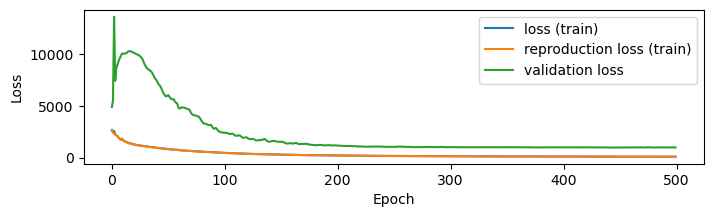

In [931]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), train_losses, label = "loss (train)")
plt.plot(range(epochs), train_r_losses, label = "reproduction loss (train)")
plt.plot(range(epochs), validation_loss, label = 'validation loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

<Figure size 400x200 with 0 Axes>

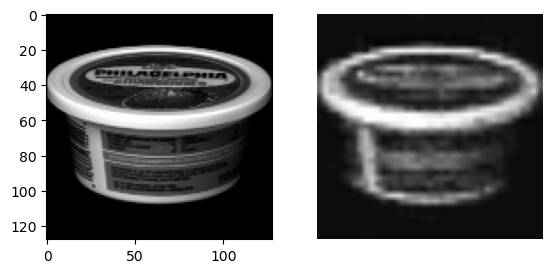

In [940]:
model_overfit.eval()
# See reconstruction of an image in the training set
examples = enumerate(train_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.to(DEVICE)
    x_hat, _, _ = model_overfit(x)

def show_image_in_batch(images, reconstructed_images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    reconstructed_images = reconstructed_images.view(reconstructed_images.shape[0], input_size[-2], input_size[-1])
    plt.figure(figsize=(4,2))
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    axs[1].imshow(reconstructed_images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, x_hat, idx=0)

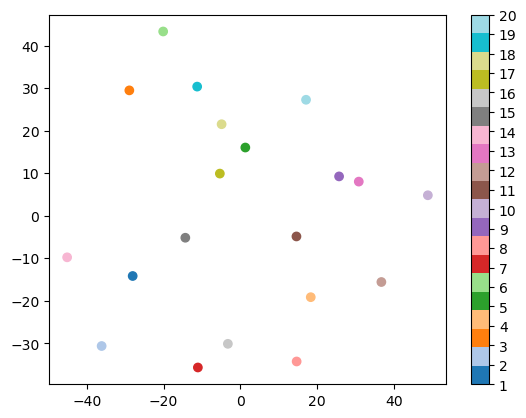

In [933]:
plot_latent_space_pca(model_overfit, train_loader, n_batches=200)